In [51]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis

#classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [162]:
import networkx as nx
import community.community_louvain as community_louvain # pip install community


In [53]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

## Classify

In [54]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe


In [55]:
def run_pca(feature_arr):
    dataframe = pd.DataFrame(index=range(len(feature_arr)),columns=range(len(feature_arr[0])))
    for i in range(len(feature_arr)):
        dataframe.iloc[i]=feature_arr[i]
        
    x=dataframe.loc[:,dataframe.columns.values].values
    
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    return principalComponents

def box_cox_transform(dataframe):
    fitted_ef, fitted_lambda1 = stats.boxcox(dataframe.mean_ef)
    dataframe.mean_ma=dataframe.mean_ma+0.1
    fitted_ma, fitted_lambda2 = stats.boxcox(dataframe.mean_ma)
    fitted_wd, fitted_lambda3 = stats.boxcox(dataframe.length_of_encounter)
    fitted_mc, fitted_lambda3 = stats.boxcox(dataframe.mean_concentration)
    dataframe.std_whiff=dataframe.std_whiff+0.1
    fitted_sw, fitted_lambda3 = stats.boxcox(dataframe.std_whiff)
    dataframe['mean_ef']=fitted_ef
    dataframe['mean_ma']=fitted_ma
    dataframe['log_whiff']=fitted_wd
    dataframe['std_whiff']=fitted_mc
    dataframe['mean_concentration']=fitted_sw
    
def remove_motion_effect(dataframe):
    whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    moving_avg = smf.ols(formula='whiff_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    sw = smf.ols(formula='std_whiff ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()


    dataframe['log_whiff']=whiff_duration.resid
    dataframe['mean_ef'] = whiff_frequency.resid
    dataframe['whiff_ma'] = moving_avg.resid
    dataframe['mean_concentration'] = mc.resid
    dataframe['std_whiff'] = sw.resid

In [56]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
            
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff


def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T):
    for i in range(500):
        xx,dx,n,t=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        
    return X,y,D,N,T

In [57]:
# df_windy=create_class_column_fullts(pd.read_hdf(dir+'Windy/WindyMASigned.h5'))
# df_notwindy=create_class_column_fullts(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
# df_forest=create_class_column_fullts(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

fdf_windy = pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

### Collect Train & Test features



In [133]:
lookback_time = 10

desert = pd.concat([fdf_notwindy,fdf_windy,fdf_forest])
desert.reset_index(inplace=True, drop=True)
trainset= desert 


D_train=[]
D_test=[]
mean_time_train=[]
mean_time_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)
    

In [134]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

In [135]:
# y=traindf.distance
# x=traindf.loc[traindf.distance.notnull(), column_names].values
# x = sm.add_constant(x)
# x[np.isnan(x)] =0
# olsmod = sm.OLS(y, x)
# olsres = olsmod.fit()
# ypred = olsres.predict(x)
# print(olsres.rsquared)

In [136]:
# traindf['predicted_distance']=ypred
# traindf.to_hdf(dir+'KF/Desert_Predictions.h5', key='traindf', mode='w')

In [293]:
# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = networkx.to_networkx_graph(assignment_matrix, create_using=networkx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]
    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix

In [286]:
REMOVE_Y_CORR = True
y=dataframe.distance

In [312]:
n = []
for i in range(len(X)):
    n.append(X[i].name)

In [316]:
dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]

In [319]:
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

In [359]:
new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
    

In [364]:
new_list

['mc_min',
 'wd_min',
 'wd_mean',
 'st_min',
 'mc_max',
 'mc_std_dev',
 'st_max',
 'st_std_dev',
 'mc_mean',
 'st_mean',
 'mc_k',
 'wd_k',
 'ma_k',
 'st_k',
 'wf_min',
 'wf_max',
 'wf_mean',
 'wf_std_dev',
 'wf_k',
 'wd_max',
 'wd_std_dev',
 'ma_max',
 'ma_mean',
 'ma_std_dev',
 'ma_min']

In [287]:
dataframe=traindf
X=[dataframe.mc_min,dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
     dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
     dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
     dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
     dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]


In [288]:
# X = [dataframe.mc_mean, dataframe.st_mean,
#      dataframe.wf_std_dev,dataframe.st_min,dataframe.ma_std_dev,dataframe.mc_max]

In [292]:
corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)

{0: 3, 1: 7, 2: 2, 3: 7, 4: 4, 5: 5, 6: 6, 7: 6, 8: 6, 9: 8, 10: 3, 11: 0, 12: 3, 13: 0, 14: 4, 15: 1, 16: 0, 17: 0, 18: 0, 19: 4, 20: 3, 21: 7, 22: 2, 23: 7, 24: 4}


In [371]:
new_list

['mc_min',
 'wd_min',
 'wd_mean',
 'st_min',
 'mc_max',
 'mc_std_dev',
 'st_max',
 'st_std_dev',
 'mc_mean',
 'st_mean',
 'mc_k',
 'wd_k',
 'ma_k',
 'st_k',
 'wf_min',
 'wf_max',
 'wf_mean',
 'wf_std_dev',
 'wf_k',
 'wd_max',
 'wd_std_dev',
 'ma_max',
 'ma_mean',
 'ma_std_dev',
 'ma_min']

/tmp/ipykernel_4244/4063663562.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_list)


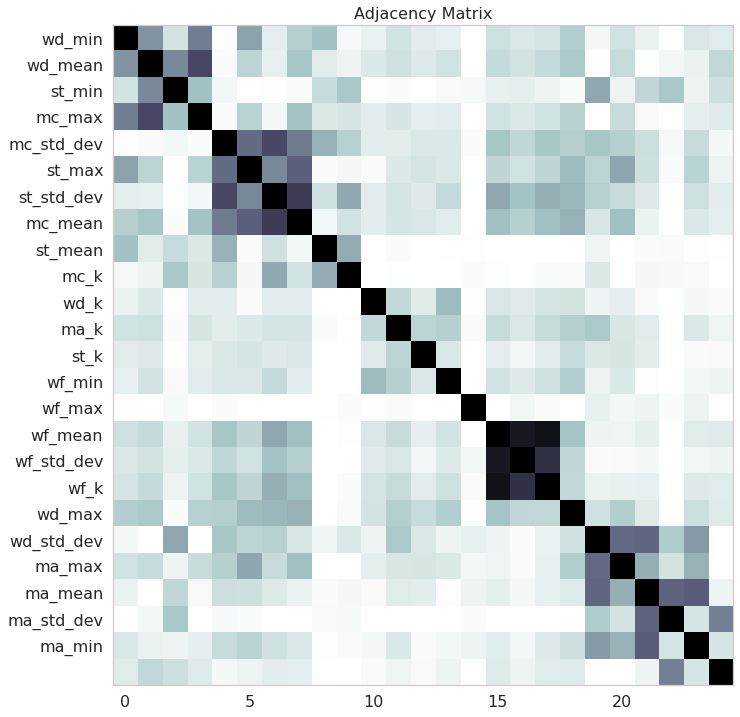

In [374]:
f,(ax) = plt.subplots(1,1,figsize=(10,10))
ax.imshow(adjacency_matrix,cmap='bone_r',  aspect='auto')


ax.grid(False)
ax.set_title('Adjacency Matrix')
ax.set_yticklabels(new_list)
ax.yaxis.set_major_locator(plt.MaxNLocator(25))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/community_selected_params.jpeg', dpi=300, bbox_inches = "tight")

/tmp/ipykernel_4244/4006004151.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels( new_list_label,rotation=90)


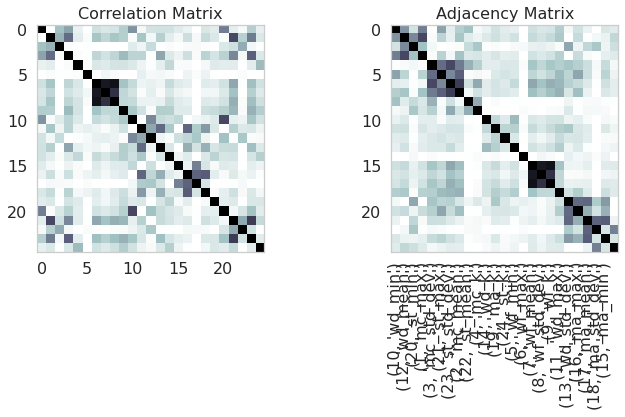

In [328]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(corr_mat,cmap='bone_r')
ax2.imshow(adjacency_matrix,vmin=0,vmax=1,cmap='bone_r')


ax1.grid(False)
ax2.grid(False)
# ax2.axis(False)
ax1.set_title('Correlation Matrix')
ax2.set_title('Adjacency Matrix')
# mpl_functions.adjust_spines(ax1,['left','bottom'],
#                             spine_locations={'left': 8}, 
#                             smart_bounds=True,                            
#                             yticks=[0,5,10,15,20,25],
#                             xticks=[0,5,10,15,20,25],
# #                             yticks=[0,5],
# #                             xticks=[0,5],
#                             linewidth=0.5)
# mpl_functions.adjust_spines(ax2,['left','bottom'],
#                             spine_locations={'left': 8}, 
#                             smart_bounds=True,                            
#                             yticks=[0,5,10,15,20,25],
#                             xticks=[0,5,10,15,20,25],
# #                             yticks=[0,5],
# #                             xticks=[0,5],
#                             linewidth=0.5)
# ax2.set_xticklabels(new_list_label, rotation=90)
ax2.xaxis.set_major_locator(plt.MaxNLocator(25))
ax2.set_xticklabels( new_list_label,rotation=90)
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/community_selected_params.jpeg', dpi=300, bbox_inches = "tight")

In [263]:
import matplotlib.cm as cm

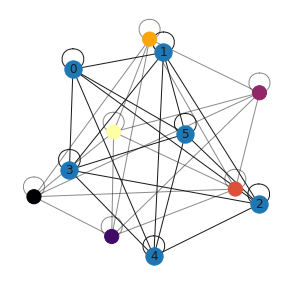

In [269]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.grid(False)
ax.axis(False)
pos = nx.spring_layout(G)
shapes = 'so^>v<dph8'
cmap = cm.get_cmap('inferno', max(louvain_community_dict.values()) + 1)
# nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, louvain_community_dict.keys(), node_size=200,cmap=cmap, 
                       node_color=list(louvain_community_dict.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw(G, labels=louvain_community_dict, with_labels = True)
# for node, color in louvain_community_dict.items():
#     nx.draw_networkx_nodes(G, pos, [node], node_size=100,
#                            node_color=[cmap.colors[color]],
#                            node_shape=shapes[color])

f.savefig('../../Figure/select_param_nx.jpeg', dpi=300, bbox_inches = "tight")

## Linear Distance Analysis - OLS


### Calculate statistics of timed train and test data

In [11]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)


In [12]:
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)
# traindf['mean_concentration_continuous'] = np.delete(MCTrain, c1)


In [13]:
distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

distance.rsquared

0.620818004651991

In [56]:
# traindf.to_hdf(dir+'Desert/WindyTrainDf.h5', key='combtest', mode='w')

### $AIC$ and $R^2$

In [26]:
df1 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_1.h5')
df2 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_3.h5')
df3 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_5.h5')
df4 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_10.h5')
df5 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_20.h5')


# aic = pd.read_hdf(dir+'Windy/Desert_Aic.h5')

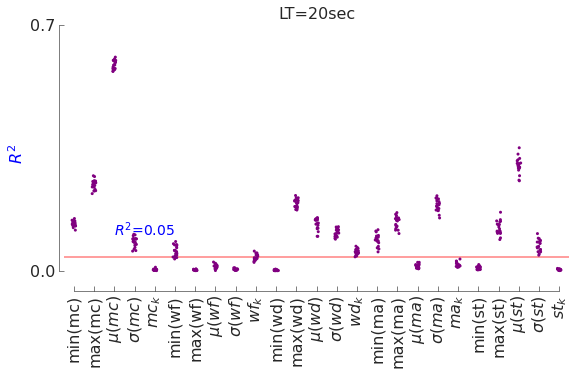

In [47]:
f,ax=plt.subplots(1,1,figsize=(8,5))
# sns.stripplot(data=df1, ax=ax, dodge=True, size=3, color='Black',label='LT=1sec',rasterized=True)
# sns.stripplot(data=df2, ax=ax, dodge=True, size=3, color='Green',label='LT=3sec',rasterized=True)
# sns.stripplot(data=df3, ax=ax, dodge=True, size=3, color='Blue',label='LT=5sec',rasterized=True)
# sns.stripplot(data=df4, ax=ax, dodge=True, size=3, color='Red',label='LT=10sec',rasterized=True)
sns.stripplot(data=df5, ax=ax, dodge=True, size=3, color='Purple',label='LT=20sec',rasterized=True)
ax.grid(False)
label=['min(mc)','max(mc)','$\mu(mc)$','$\sigma(mc)$', '$mc_k$',
      'min(wf)','max(wf)','$\mu(wf)$','$\sigma(wf)$', '$wf_k$',
      'min(wd)','max(wd)','$\mu(wd)$','$\sigma(wd)$', '$wd_k$',
      'min(ma)','max(ma)','$\mu(ma)$','$\sigma(ma)$', '$ma_k$',
      'min(st)','max(st)','$\mu(st)$','$\sigma(st)$', '$st_k$']
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(0.04, color = 'red', alpha=0.5)
ax.set_ylabel('$R^2$',c='blue')

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5}, 
                            smart_bounds=True,                            
                            yticks=[0,0.7],
                            linewidth=0.5)
ax.set_xticklabels(label, rotation=90)
# ax.set_title('Bootstrapped $R^2$ Desert')
ax.set_title('LT=20sec')

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
ax.text(2,0.1,'$R^2$=0.05',color='black',fontsize='14',c='blue')
# f.savefig('../../Figure/lt-20.jpeg', dpi=300, bbox_inches = "tight")

In [45]:
col_name=[]
for i in range(len(df.columns)):
    if (df.iloc[:,i].max() >= 0.05):
        col_name.append(df.columns[i])
        
col_name

['mc_min',
 'mc_max',
 'mc_mean',
 'mc_std_dev',
 'wf_max',
 'wf_mean',
 'wf_std_dev',
 'wd_min',
 'wd_max',
 'wd_mean',
 'wd_std_dev',
 'ma_max',
 'ma_mean',
 'ma_std_dev',
 'st_min',
 'st_max',
 'st_mean',
 'st_std_dev']

In [46]:
import itertools
column_names=col_name
rsquaredres=[]
aicres=[]
para_list = []
# pval=[]
# bicres=[]

for i in range(1,10):
    sub_parameter_list = list(itertools.combinations(column_names,i))
  
    for elements in sub_parameter_list:
        para_list.append(elements)
        y=traindf.distance
        x = sm.add_constant(traindf.loc[traindf.distance.notnull(), elements].values)
        olsmod = sm.OLS(y, x)
        olsres = olsmod.fit()
        rsquaredres.append(olsres.rsquared)
        aicres.append(olsres.aic)
#         pval.append(olsres.f_pvalue)
#         bicres.append(olsres.bic)
        
combtest=pd.DataFrame()
combtest['rsquared']=rsquaredres
combtest['aic']=aicres
combtest['parameters']=para_list
# combtest['fpvalue']=pval
# combtest['bic']=bicres


combtest['n_para']=np.zeros(len(combtest))
for i in range(len(combtest)):
    combtest.n_para[i]=len(combtest.parameters[i])

In [47]:
# combtest.to_hdf(dir+'Desert/HWSRsquaredAicCombinations.h5', key='combtest', mode='w')
# combtest.loc[(np.where(combtest.n_para==1))].sort_values(by=['aic'],ascending=True)

In [48]:
aic_min=[]
for i in range(1,int(combtest.n_para.max()+1)):
    aic_min.append(np.min(combtest.aic.iloc[(np.where(combtest.n_para==i))]))

aic_delta=[]
for i in range(len(aic_min)):
    if i ==0:
        aic_delta.append(0)
    else:
        aic_delta.append(aic_min[i]-aic_min[i-1])
        
aic_table=pd.DataFrame()
aic_table['aic_min'] = aic_min
aic_table['aic_delta']=aic_delta
aic_table

,aic_min,aic_delta
0,10783.300540,0.000000
1,10723.218079,-60.082461
2,10675.423890,-47.794189
3,10642.380524,-33.043366
4,10620.871455,-21.509068
5,10613.424645,-7.446810
6,10602.485186,-10.939460
7,10597.037575,-5.447611
8,10588.103231,-8.934343


In [49]:
# aic_table.to_hdf(dir+'Desert/HWSAicDeltaTab.h5', key='aic_table', mode='w')

In [50]:
for i in range(1,len(aic_table)):
#     print(i)
    print(*(combtest.parameters[combtest.aic==(combtest.aic.loc[(np.where(combtest.n_para==i))]).min()]))

('mc_mean',)
('mc_mean', 'ma_std_dev')
('mc_mean', 'wf_std_dev', 'ma_std_dev')
('mc_mean', 'wf_std_dev', 'wd_min', 'ma_std_dev')
('mc_mean', 'wf_std_dev', 'wd_min', 'ma_std_dev', 'st_std_dev')
('mc_mean', 'wf_std_dev', 'wd_min', 'wd_max', 'ma_std_dev', 'st_std_dev')
('mc_mean', 'wf_std_dev', 'wd_min', 'wd_max', 'ma_mean', 'ma_std_dev', 'st_max')
('mc_mean', 'wf_std_dev', 'wd_max', 'wd_mean', 'ma_mean', 'ma_std_dev', 'st_max', 'st_mean')


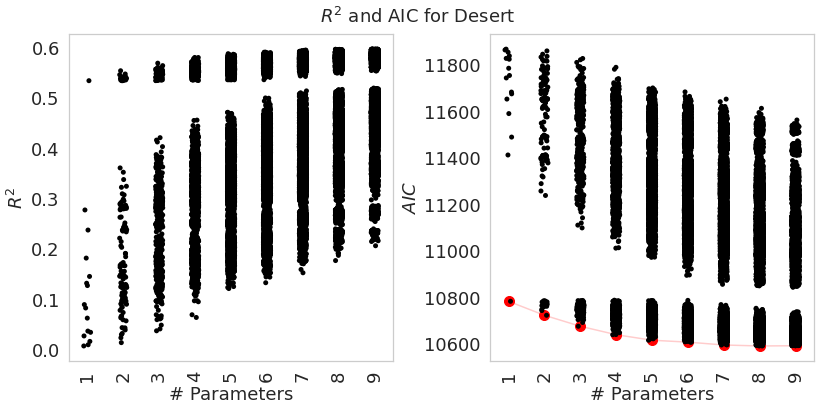

In [17]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(12,6))
ax.grid(False)
ax.set_ylabel('$R^2$')
sns.stripplot(x=combtest.n_para,y=combtest.rsquared,data=combtest, 
              ax=ax, color='black',
              dodge=True, size=5)

ax.set_ylabel('$R^2$')
ax.set_xlabel('# Parameters')
ax.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)
# ax.set_title('$R^2$')

sns.stripplot(x=combtest.n_para,y=combtest.aic, data=combtest, color='black',
              ax=ax1,dodge=True, size=5)
ax1.set_xlabel('# Parameters')
ax1.set_ylabel('$AIC$')
ax1.grid(False)
ax1.scatter(np.arange(0,len(aic_table),1),aic_min,c='red', marker='o', facecolor=None,s=100)
ax1.plot(np.arange(0,len(aic_table),1),aic_min,c='red',alpha=0.2)

ax1.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)

f.tight_layout(pad=3)
f.suptitle('$R^2$ and AIC for HWS')
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/R2_AIC_Comb_RM.jpeg', dpi=300, bbox_inches = "tight")

In [49]:
# model=smf.ols(formula=""" mc_mean ~ wf_std_dev""", data=traindf).fit()
# print(model.summary())

/tmp/ipykernel_125700/3156853093.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[5,50])


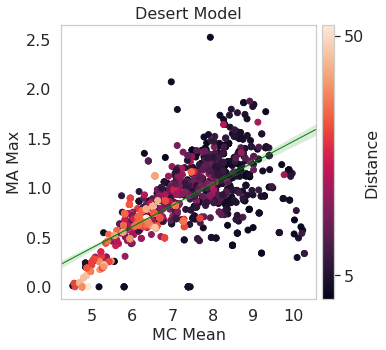

In [111]:
f,ax=plt.subplots(1,1,figsize=(5.5,5))
ax.grid(False)
dat=traindf
v1=dat.mc_mean
v2=dat.st_mean
v3=dat.distance
var1 = ax.scatter(v1,v2, c=v3)

ax.set_title('Desert Model')
g1 = sns.regplot(x=v1,y=v2 , data=dat,
            ax=ax, line_kws={'color':'green','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('MC Mean')
ax.set_ylabel('MA Max')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[5,50])
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Distance', rotation=90, labelpad=0)
# f.suptitle('$R^2$ and AIC for Desert')
figurefirst.mpl_functions.set_fontsize(f, 16)
# ax.text(4.5,10,'$R^2=0.027',color='blue',fontsize=10)
f.tight_layout(pad=1)

# f.savefig('../../Figure/MC_stmean.jpeg', dpi=300, bbox_inches = "tight")

In [25]:
from scipy import ndimage

EPS = np.finfo(float).eps
def mutual_information_2d(x, y, sigma=1, normalized=True):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (10000, 10000)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                 output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
                / np.sum(jh * np.log(jh))) - 1
    else:
        mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
               - np.sum(s2 * np.log(s2)))

    return mi

In [29]:
mutual_information_2d(traindf.mc_mean,traindf.wf_std_dev)

0.6237261325602794

In [23]:
def mutual_info(x, y, bins=[10000, 10000]):
    """Calculate mutual information based on 2D histrograms
    """
    hist = np.histogram2d(x, y, bins, normed=True)[0]
    joint_prob = hist / np.sum(hist)

    hist = np.histogram(x, bins[0], density=True)[0]
    probs_x = hist / np.sum(hist)

    hist = np.histogram(y, bins[1], density=True)[0]
    probs_y = hist / np.sum(hist)

    probs = joint_prob / (np.reshape(probs_x, [-1, 1]) * probs_y)

    # use masked array to avoid NaNs
    info = (joint_prob * np.ma.log2(probs)).sum()

    return info

mutual_info(traindf.mc_mean,traindf.wd_mean)

/tmp/ipykernel_136646/267784704.py:13: RuntimeWarning: invalid value encountered in true_divide
  probs = joint_prob / (np.reshape(probs_x, [-1, 1]) * probs_y)


8.442297294007197

### Low pass filtering


In [6]:
x = pd.read_hdf('~/DataAnalysis/data/Sprints/'+'LpfAnalysis/desert_1.0.h5')
len(x)

764

In [ ]:
cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
lookback_time = 10
rs=[]
for i in range(len(cutoff)):
    desert = pd.concat([fdf_notwindy,fdf_windy])
    desert.reset_index(inplace=True, drop=True)
    trainset= low_pass_filter(desert,cutoff[i]) 
    # testset = fdf_forest

    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []


    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,
                                                                                        distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

    def calc_val(X):
        return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
    #     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
    column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
                 'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
                 'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
                 'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
                 'st_min','st_max','st_mean','st_std_dev','st_k']

    ## Done separately because Forest dataset has two classes
    ## Training set
    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
    traindf['nwhiffs'] = np.delete(Nrows_train, c1)



    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

    rs.append(distance.f_pvalue)



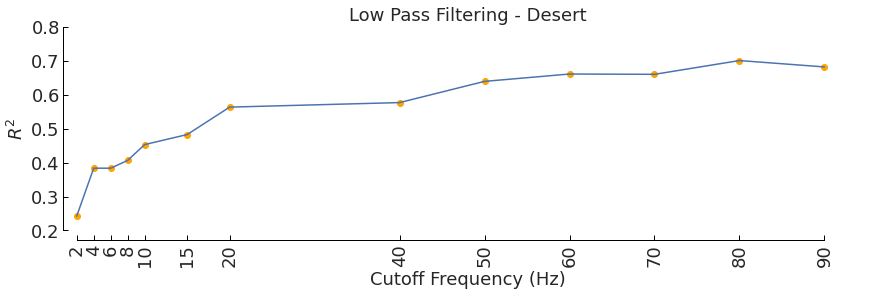

In [10]:
# cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
# rsq=rs
# rsq=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,0.24205416850966,
#              0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
#              0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
#              0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])

rsq=np.array([0.24205416850966,
             0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
             0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
             0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])
rsq1=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,
              0.24205416850966])
cutoff=np.array([2,4,6,8,10,15,20,40,50,60,70,80,90])
cutoff1=np.array([0.1,0.2,0.5,1,2])
f,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(cutoff,rsq)
# ax.plot(cutoff1,rsq1,'--',c='b')
ax.scatter(cutoff,rsq,c='orange')
# ax.scatter(cutoff1,rsq1,c='orange')
ax.grid(False)
ax.set_xlabel('Cutoff Frequency (Hz)')
ax.set_ylabel('$R^2$')
ax.set_xlim(1.6,)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[2,4,6,8,10,15,20,40,50,60,70,80,90],
#                             yticks = [-0.01,0.01],
                            linewidth=1)

plt.xticks(rotation=90)
ax.set_title('Low Pass Filtering - Desert')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/LPF_OnCont.jpeg', dpi=300, bbox_inches = "tight")

### Code for generating R2 vs LT plots 

In [ ]:
t=[0.5,1,2,3,4,5,8,10,20]
r =[]

def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

desert = pd.concat([fdf_notwindy,fdf_windy, fdf_forest])
desert.reset_index(inplace=True, drop=True)
trainset= desert 

for i in range(len(t)):

    lookback_time = t[i]

  
    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []

    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

     
    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
    traindf['nwhiffs'] = np.delete(Nrows_train, c1)
    
    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

    r.append(distance.rsquared)

In [ ]:
# def get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters):
#     y=dataframe_cont.iloc[same_time_location]
#     A = y.time.round(0) - duration_of_encounters
#     B = y.time.round(0)
#     timed_rows_cont = dataframe_cont.loc[(dataframe_cont.time > A) & (dataframe_cont.time < B)]
     
#     return np.mean(timed_rows_cont.odor)

# def get_timed_rows(dataframe,dataframe_cont,duration_of_encounters):
#     x = dataframe.sample(1)
#     A = x.mean_time.values.round(0) - duration_of_encounters
#     B = x.mean_time.values.round(0)

#     if (np.where(dataframe_cont.time.round(0)==B[0])[0].size == 0):
#         #find index of closest value in continuous data frame
#         same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]     
#     else:
#         same_time_location = np.where(dataframe_cont.time.round(0) == B[0])[0][0]
#     same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]
#     timed_rows_odor_mean = get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters)
#     timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
#     return timed_rows,timed_rows_odor_mean
    
# def get_timed_encounter_stats(dataframe,dataframe_cont, distance_class, duration_of_encounters):
#     df_q = dataframe.query('type == ' + str(distance_class))   
#     df_q.reset_index(inplace=True, drop=True)     
        
#     df_q_cont = dataframe_cont.query('type == ' + str(distance_class))   
#     df_q_cont.reset_index(inplace=True, drop=True)     
    
#     Nrows,mean_conc = get_timed_rows(df_q,df_q_cont,duration_of_encounters)
#     avg_dist = np.mean(Nrows.avg_dist_from_source)
#     mean_time_whiff=np.mean(Nrows.mean_time)
# #     mean_conc=np.mean(Nrows_cont.odor)
#     pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
#     return pack_data,avg_dist,len(Nrows),mean_time_whiff,mean_conc


# def gather_stat_timed(dataframe,dataframe_cont, distance_class, duration_of_encounters,X,y,D,N,T,MC):
#     for i in range(500):
#         xx,dx,n,t,mc=get_timed_encounter_stats(dataframe, dataframe_cont,
#                                                distance_class, duration_of_encounters)
#         X.append(xx)
#         D.append(dx)
#         y.append(distance_class)
#         N.append(n)
#         T.append(t)
#         MC.append(mc)

#     return X,y,D,N,T,MC
